<img src="../Fink_PrimaryLogo_WEB.jpg" width=400 />

# Fink case study: Alert statistics

## Goal

This notebook shows how to explore the various statistics that are collected in Fink regarding alerts.

## Statistics API

The [statistics](https://fink-portal.org/stats) page makes use of the REST API. If you want to further explore Fink statistics, or create your own dashboard based on Fink data, you can do also all of these yourself using the REST API. Here is an example using Python:

In [47]:
import requests
import pandas as pd

# get stats since the beginning of Fink operations
r = requests.post(
  'https://fink-portal.org/api/v1/statistics',
  json={
    'date': '', # could be also e.g. 20211103
    'output-format': 'json'
  }
)

# Format output in a DataFrame
pdf = pd.read_json(r.content)

Note `date` can be either a given night (`YYYYMMDD`), month (`YYYYMM`), year (`YYYY`), or eveything (empty string). The schema of the dataframe is the following:

In [48]:
print(pdf.columns)

Index(['basic:exposures', 'basic:fields', 'basic:n_g', 'basic:n_r',
       'basic:raw', 'basic:sci', 'class:**', 'class:AGB*', 'class:AGN',
       'class:AGN_Candidate',
       ...
       'class:gammaDor', 'class:low-mass*', 'class:multiple_object',
       'class:outflow?', 'class:post-AGB*', 'class:pulsV*SX',
       'class:simbad_gal', 'class:simbad_tot', 'key:key', 'key:time'],
      dtype='object', length=198)


In [49]:
pdf

,basic:exposures,basic:fields,basic:n_g,basic:n_r,basic:raw,basic:sci,class:**,class:AGB*,class:AGN,class:AGN_Candidate,...,class:gammaDor,class:low-mass*,class:multiple_object,class:outflow?,class:post-AGB*,class:pulsV*SX,class:simbad_gal,class:simbad_tot,key:key,key:time
0,371,234,120721,90025,267126,210746,8.0,76,86.0,153.0,...,1.0,34.0,NaN,NaN,4.0,3.0,1114,61007,ztf_20191102,1642416932927
1,421,259,94127,110370,267509,204497,10.0,62,71.0,172.0,...,2.0,12.0,NaN,NaN,4.0,3.0,622,74121,ztf_20191103,1642417432819
2,420,221,94059,84545,254314,178604,24.0,53,49.0,160.0,...,6.0,6.0,NaN,NaN,2.0,4.0,782,65090,ztf_20191104,1642417906840
3,223,151,26747,60149,124028,86896,9.0,38,30.0,75.0,...,NaN,4.0,1.0,NaN,3.0,1.0,218,34706,ztf_20191105,1642418198542
4,336,211,51308,88214,186244,139522,8.0,50,47.0,134.0,...,3.0,7.0,NaN,NaN,1.0,5.0,414,55624,ztf_20191106,1642418566575
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
536,314,168,43737,120276,267831,164013,13.0,94,117.0,97.0,...,2.0,2.0,NaN,NaN,NaN,10.0,1591,54500,ztf_20220227,1645993262263
537,394,220,62447,108121,301530,170568,24.0,75,44.0,63.0,...,11.0,8.0,1.0,NaN,5.0,1.0,770,57400,ztf_20220228,1646079710459
538,377,215,38975,68067,244895,107042,5.0,65,112.0,85.0,...,NaN,9.0,NaN,NaN,2.0,7.0,2123,43713,ztf_20220301,1646165942938
539,436,234,121295,163848,392198,285143,35.0,78,133.0,234.0,...,16.0,14.0,2.0,NaN,2.0,2.0,1789,98398,ztf_20220302,1646253367484


Let's see the number of alerts received and processed by Fink:

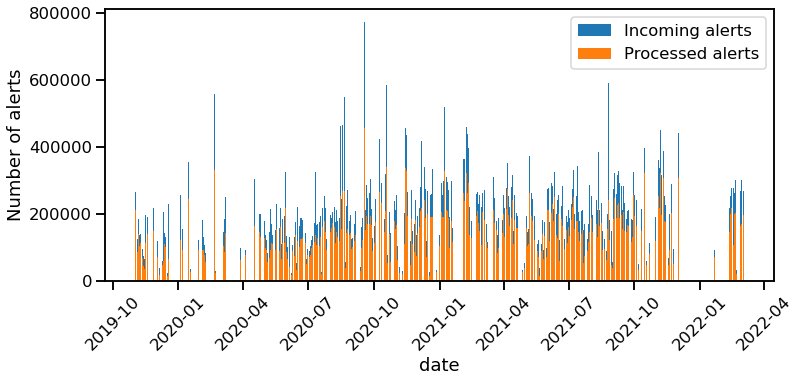

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("talk")

from astropy.time import Time

date = [
        Time(x[4:8] + '-' + x[8:10] + '-' + x[10:12]).datetime
        for x in pdf['key:key'].values
]

fig = plt.figure(figsize=(12, 5))

plt.bar(date, pdf['basic:raw'], label='Incoming alerts')
plt.bar(date, pdf['basic:sci'], label='Processed alerts')
plt.xlabel('date')
plt.ylabel('Number of alerts')
plt.xticks(rotation=45)
plt.legend();

Let's see the evolution for various classes:

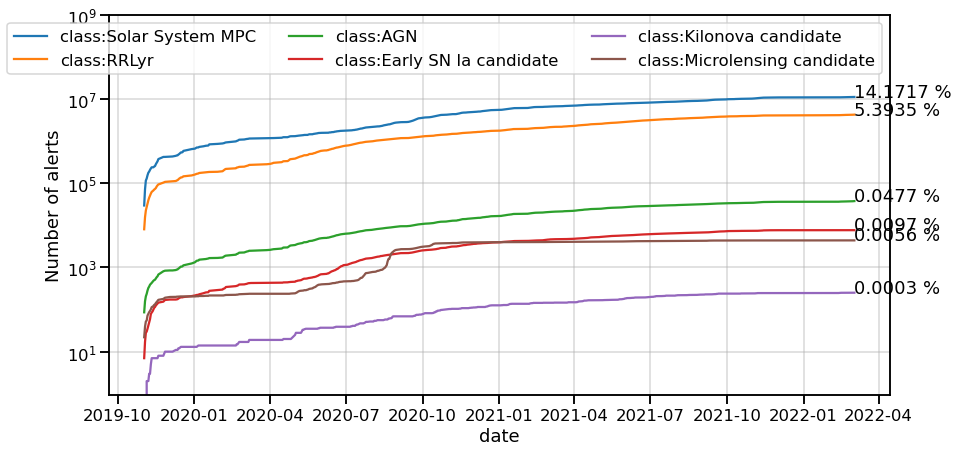

In [51]:
import numpy as np

fig = plt.figure(figsize=(14, 7))

cols = [
    'class:Solar System MPC', 'class:RRLyr', 
    'class:AGN', 'class:Early SN Ia candidate',
    'class:Kilonova candidate', 'class:Microlensing candidate',
]

# Number of alerts processed
nprocessed = np.sum(pdf[['basic:sci']].fillna(0).astype(int).values)

for col in cols:
    # replace NaN (no observations) by zeros
    vals = pdf[[col]].fillna(0).astype(int)
    
    # Cumulative
    cum = np.cumsum(vals.values)
    
    plt.plot(date, cum, label=col)
    plt.text(s='{:.4f} %'.format(cum[-1]/nprocessed * 100), x=date[-1], y=cum[-1])
    
    
plt.xlabel('date')
plt.ylabel('Number of alerts')
plt.yscale('log')
plt.ylim(None, 1e9)
plt.grid(alpha=0.5)
plt.legend(ncol=3);

## Tips

If you then want to retrieve the corresponding alerts, pay attention to the data you want to transfer:

In [54]:
import requests
import pandas as pd

def get_alerts(cols='*'):
    # Get all SN Ia candidate for 2021
    r = requests.post(
      'https://fink-portal.org/api/v1/latests',
      json={
        'class': 'Early SN Ia candidate',
        'n': '10000',
        'columns': cols,
        'startdate': '2021-01-01',
        'stopdate': '2021-12-31'
      }
    )

    # Format output in a DataFrame
    pdf = pd.read_json(r.content)
    
    return pdf

In [59]:
# all columns by default
%time pdf = get_alerts()

CPU times: user 140 ms, sys: 13.8 ms, total: 154 ms
Wall time: 3.64 s


In [61]:
len(pdf)

3728

In [62]:
len(pdf.columns)

43

In [63]:
# Just 4 columns
%time pdf2 = get_alerts(cols='i:magpsf,i:jd,i:ra,i:dec')

CPU times: user 34.7 ms, sys: 4.13 ms, total: 38.8 ms
Wall time: 1.54 s
